# Text to Image Recommendation using CLIP

## Import Libraries

In [ ]:
import pandas as pd
import torch
import clip
from PIL import Image
from tqdm import tqdm
import pickle

## Reading `Styles.csv`

In [2]:
# Load the styles.csv, adjust the path as needed
styles_df = pd.read_csv('styles.csv', on_bad_lines='skip')

# Assuming images are stored in /path/to/your/images/ and named as "<id>.jpg"
styles_df['image_path'] = styles_df['id'].apply(lambda x: f'images/{x}.jpg')

# Combine fields for richer descriptions
styles_df['description'] = styles_df[['articleType', 'baseColour', 'usage', 'productDisplayName']].apply(lambda x: ' '.join(x.astype(str)), axis=1)


In [5]:
# Load CLIP model
device = "mps" if torch.backends.mps.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## Functions for encoding Text and Image

In [6]:
def encode_text(text):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
    return text_features

def encode_image(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features


## Computing Image Features

In [9]:
def precompute_image_features(styles_df):
    image_features = {}
    # Use tqdm to wrap the iteration, providing a progress bar
    for _, row in tqdm(styles_df.iterrows(), total=styles_df.shape[0]):
        try:
            features = encode_image(row['image_path']).cpu().numpy().flatten()
            image_features[row['id']] = features
        except Exception as e:
            print(f"Error processing {row['image_path']}: {e}")
    return image_features


In [10]:
image_features = precompute_image_features(styles_df)

 15%|███████▏                                        | 6698/44424 [06:06<29:34, 21.25it/s]

Error processing images/39403.jpg: [Errno 2] No such file or directory: 'images/39403.jpg'


 36%|█████████████████▏                             | 16198/44424 [14:41<19:43, 23.86it/s]

Error processing images/39410.jpg: [Errno 2] No such file or directory: 'images/39410.jpg'


 73%|██████████████████████████████████▏            | 32312/44424 [29:17<09:31, 21.21it/s]

Error processing images/39401.jpg: [Errno 2] No such file or directory: 'images/39401.jpg'


 82%|██████████████████████████████████████▍        | 36385/44424 [33:00<05:41, 23.54it/s]

Error processing images/39425.jpg: [Errno 2] No such file or directory: 'images/39425.jpg'


 90%|██████████████████████████████████████████▎    | 40004/44424 [36:18<03:18, 22.30it/s]

Error processing images/12347.jpg: [Errno 2] No such file or directory: 'images/12347.jpg'


100%|███████████████████████████████████████████████| 44424/44424 [40:17<00:00, 18.38it/s]


## Saving the features to pickle file

In [11]:
# Assuming image_features is your dictionary of pre-computed image features
with open('image_features.pkl', 'wb') as f:
    pickle.dump(image_features, f)

## Loading Data from Pickle file (start from here if you have the pickle file)

In [12]:
with open('image_features.pkl', 'rb') as f:
    image_features = pickle.load(f)

## Product Recommendation

In [13]:
from scipy.spatial import distance

def recommend(text_query, styles_df, image_features, top_n=5):
    text_features = encode_text(text_query).cpu().numpy().flatten()
    similarities = []

    # Iterate through pre-computed image features instead of re-encoding images
    for product_id in image_features:
        image_feature = image_features[product_id]
        similarity = 1 - distance.cosine(text_features, image_feature)
        similarities.append((product_id, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    top_indices = similarities[:top_n]

    return top_indices


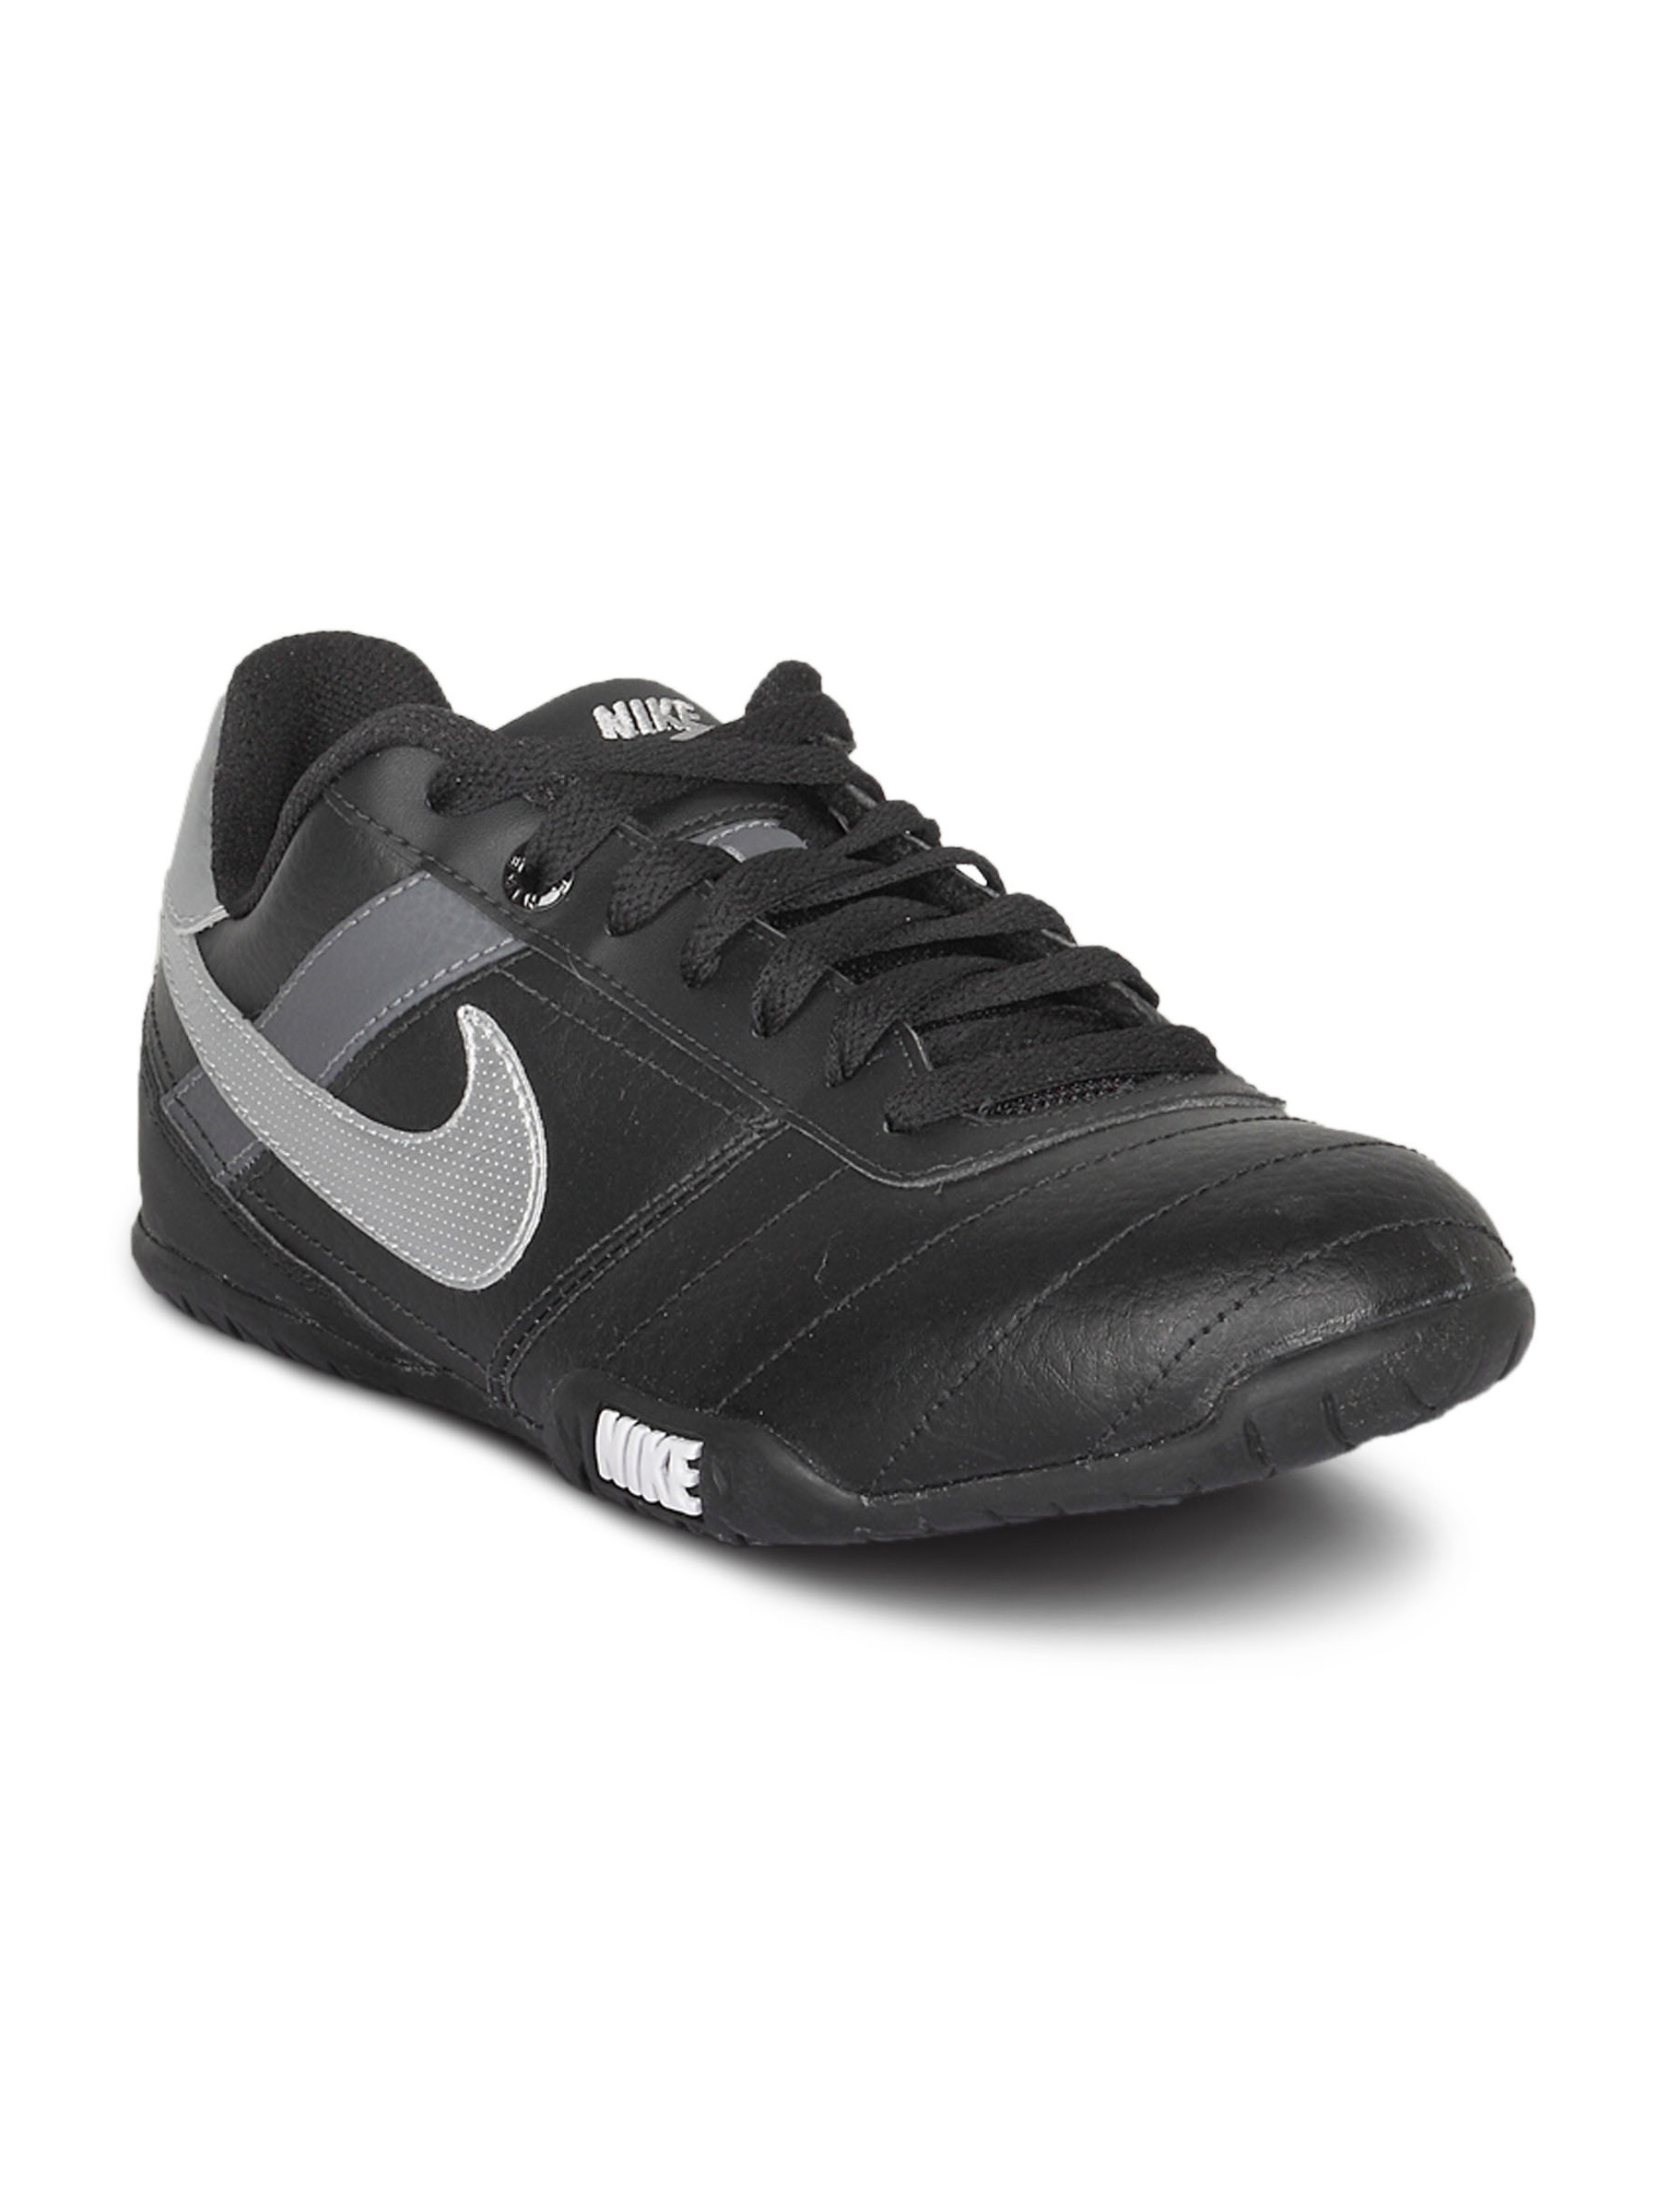

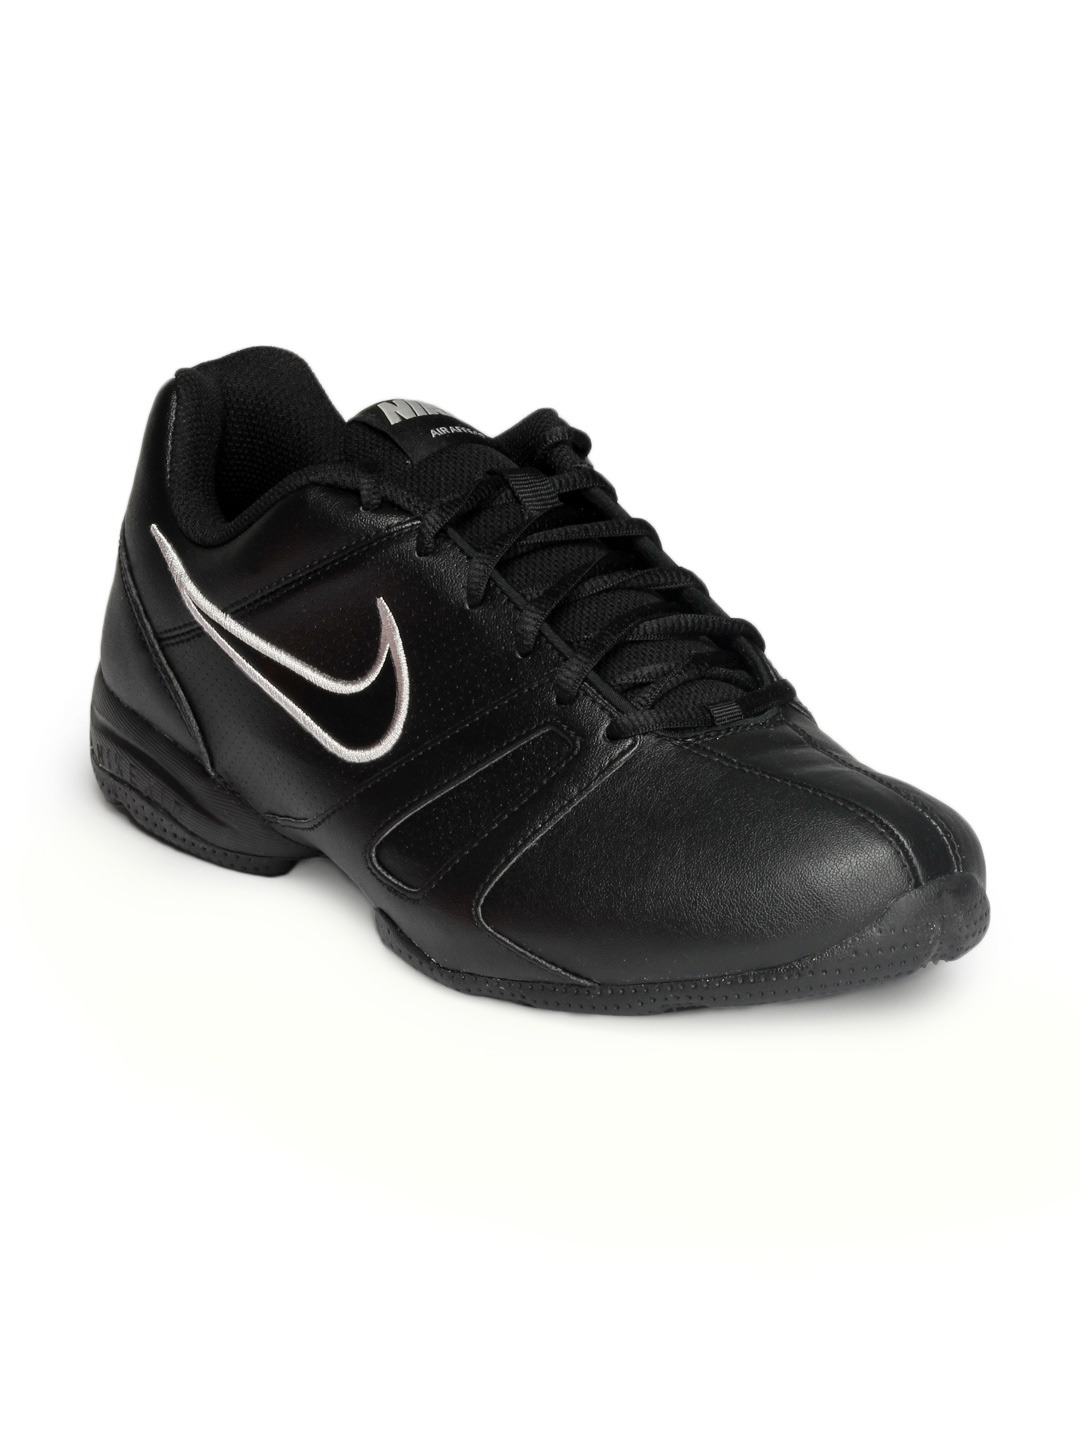

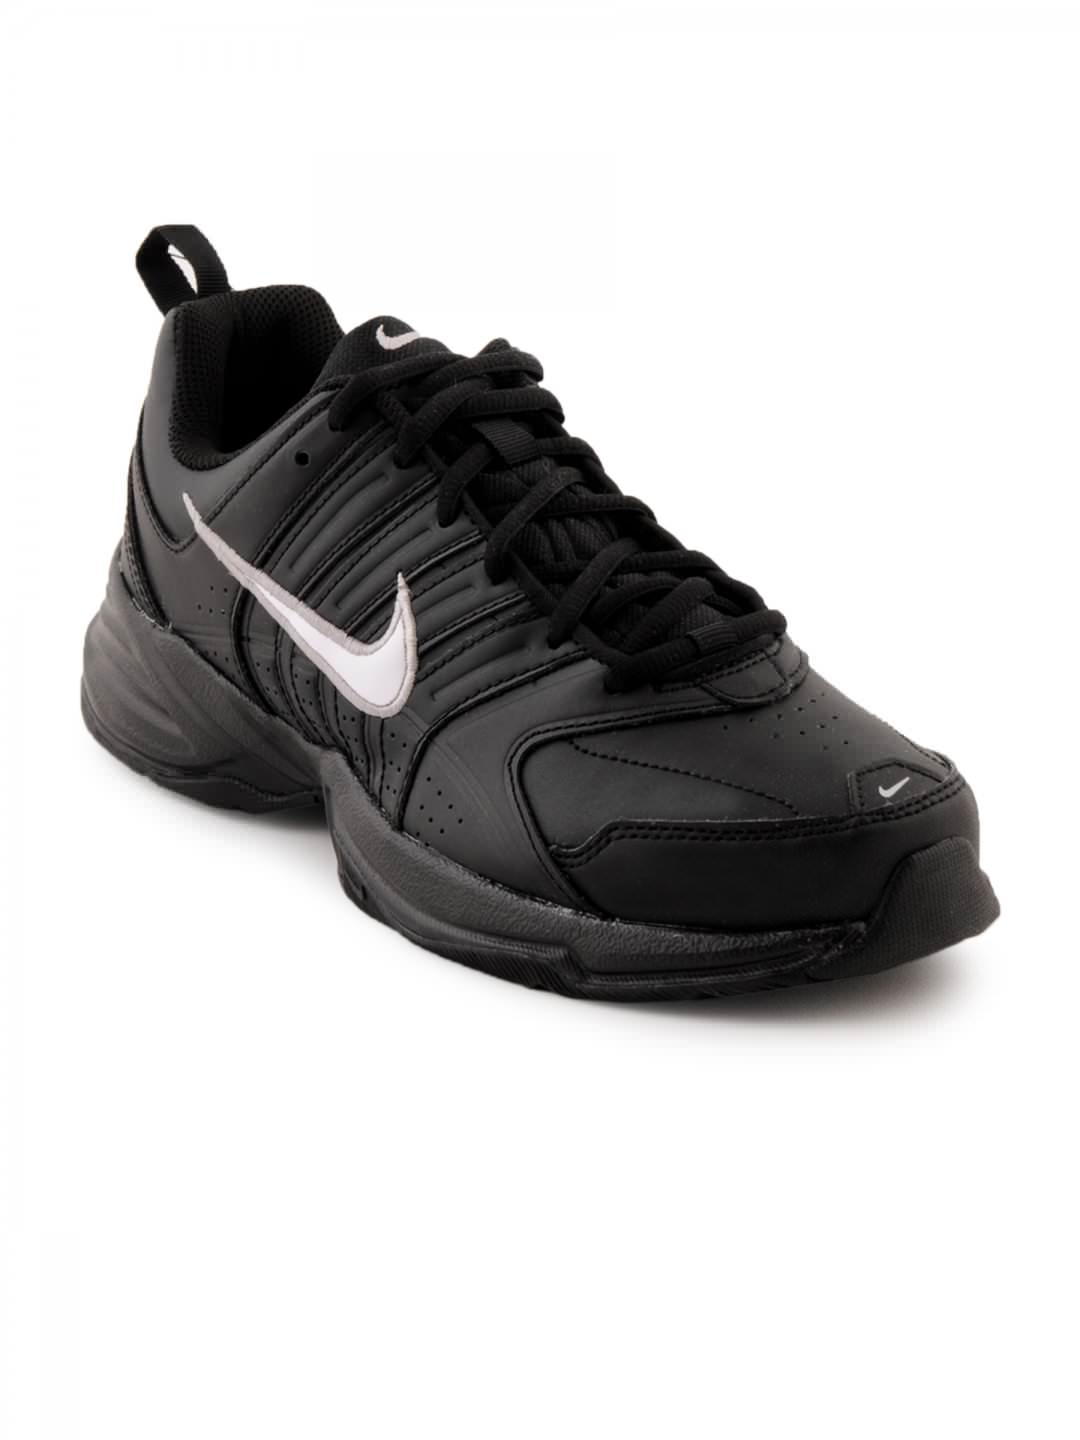

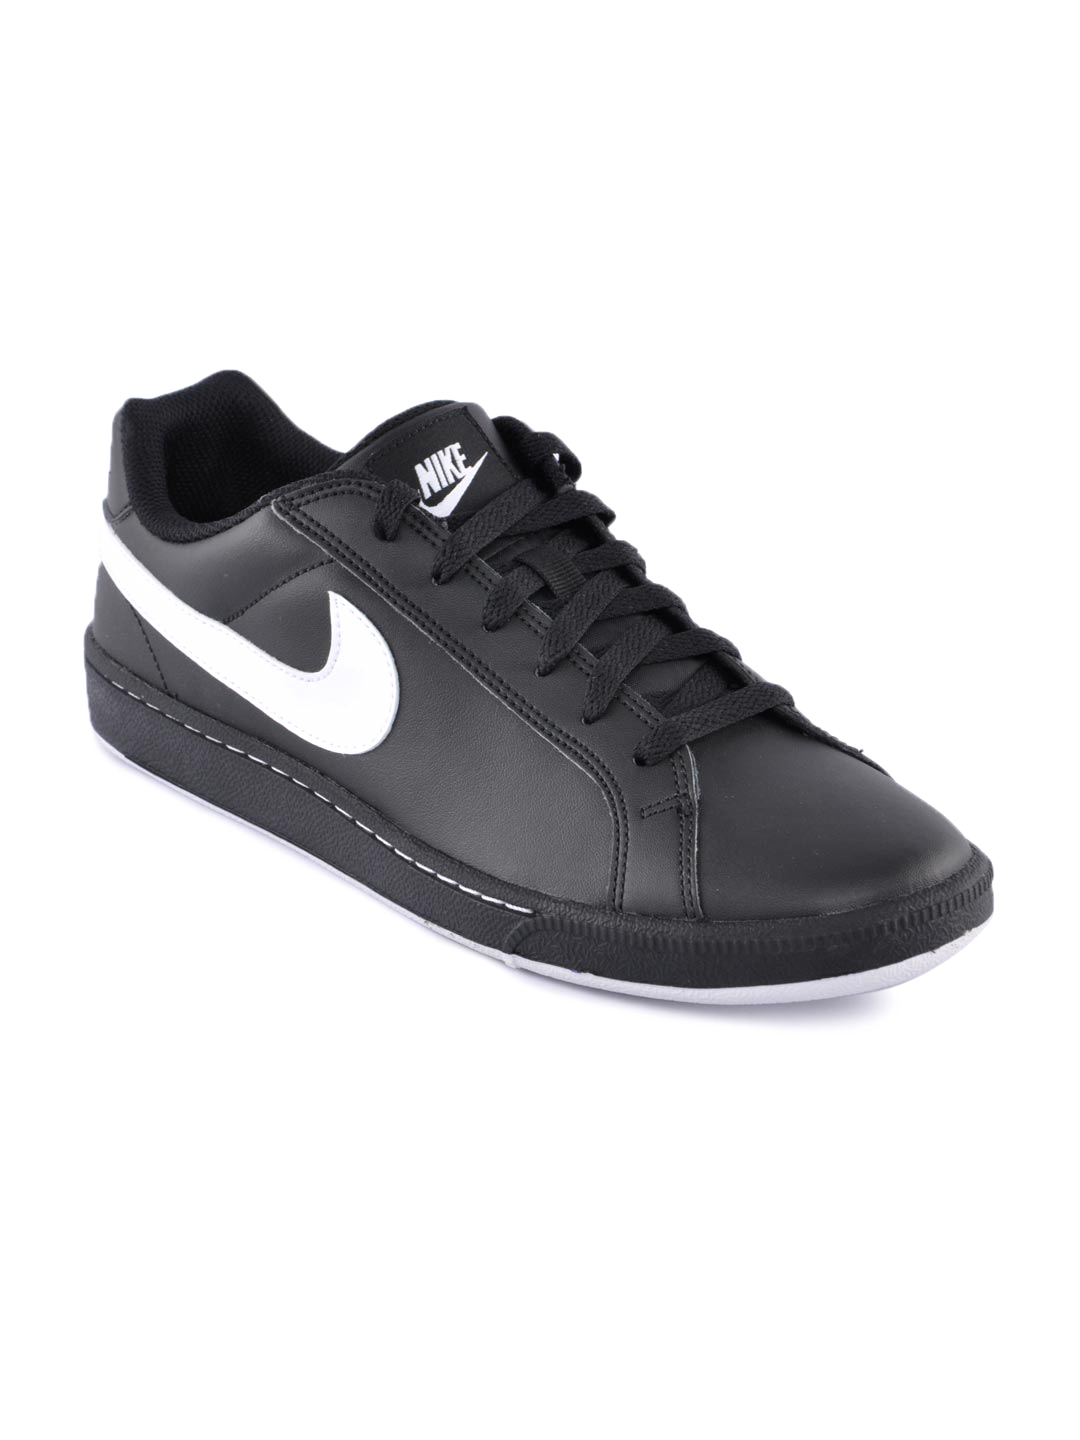

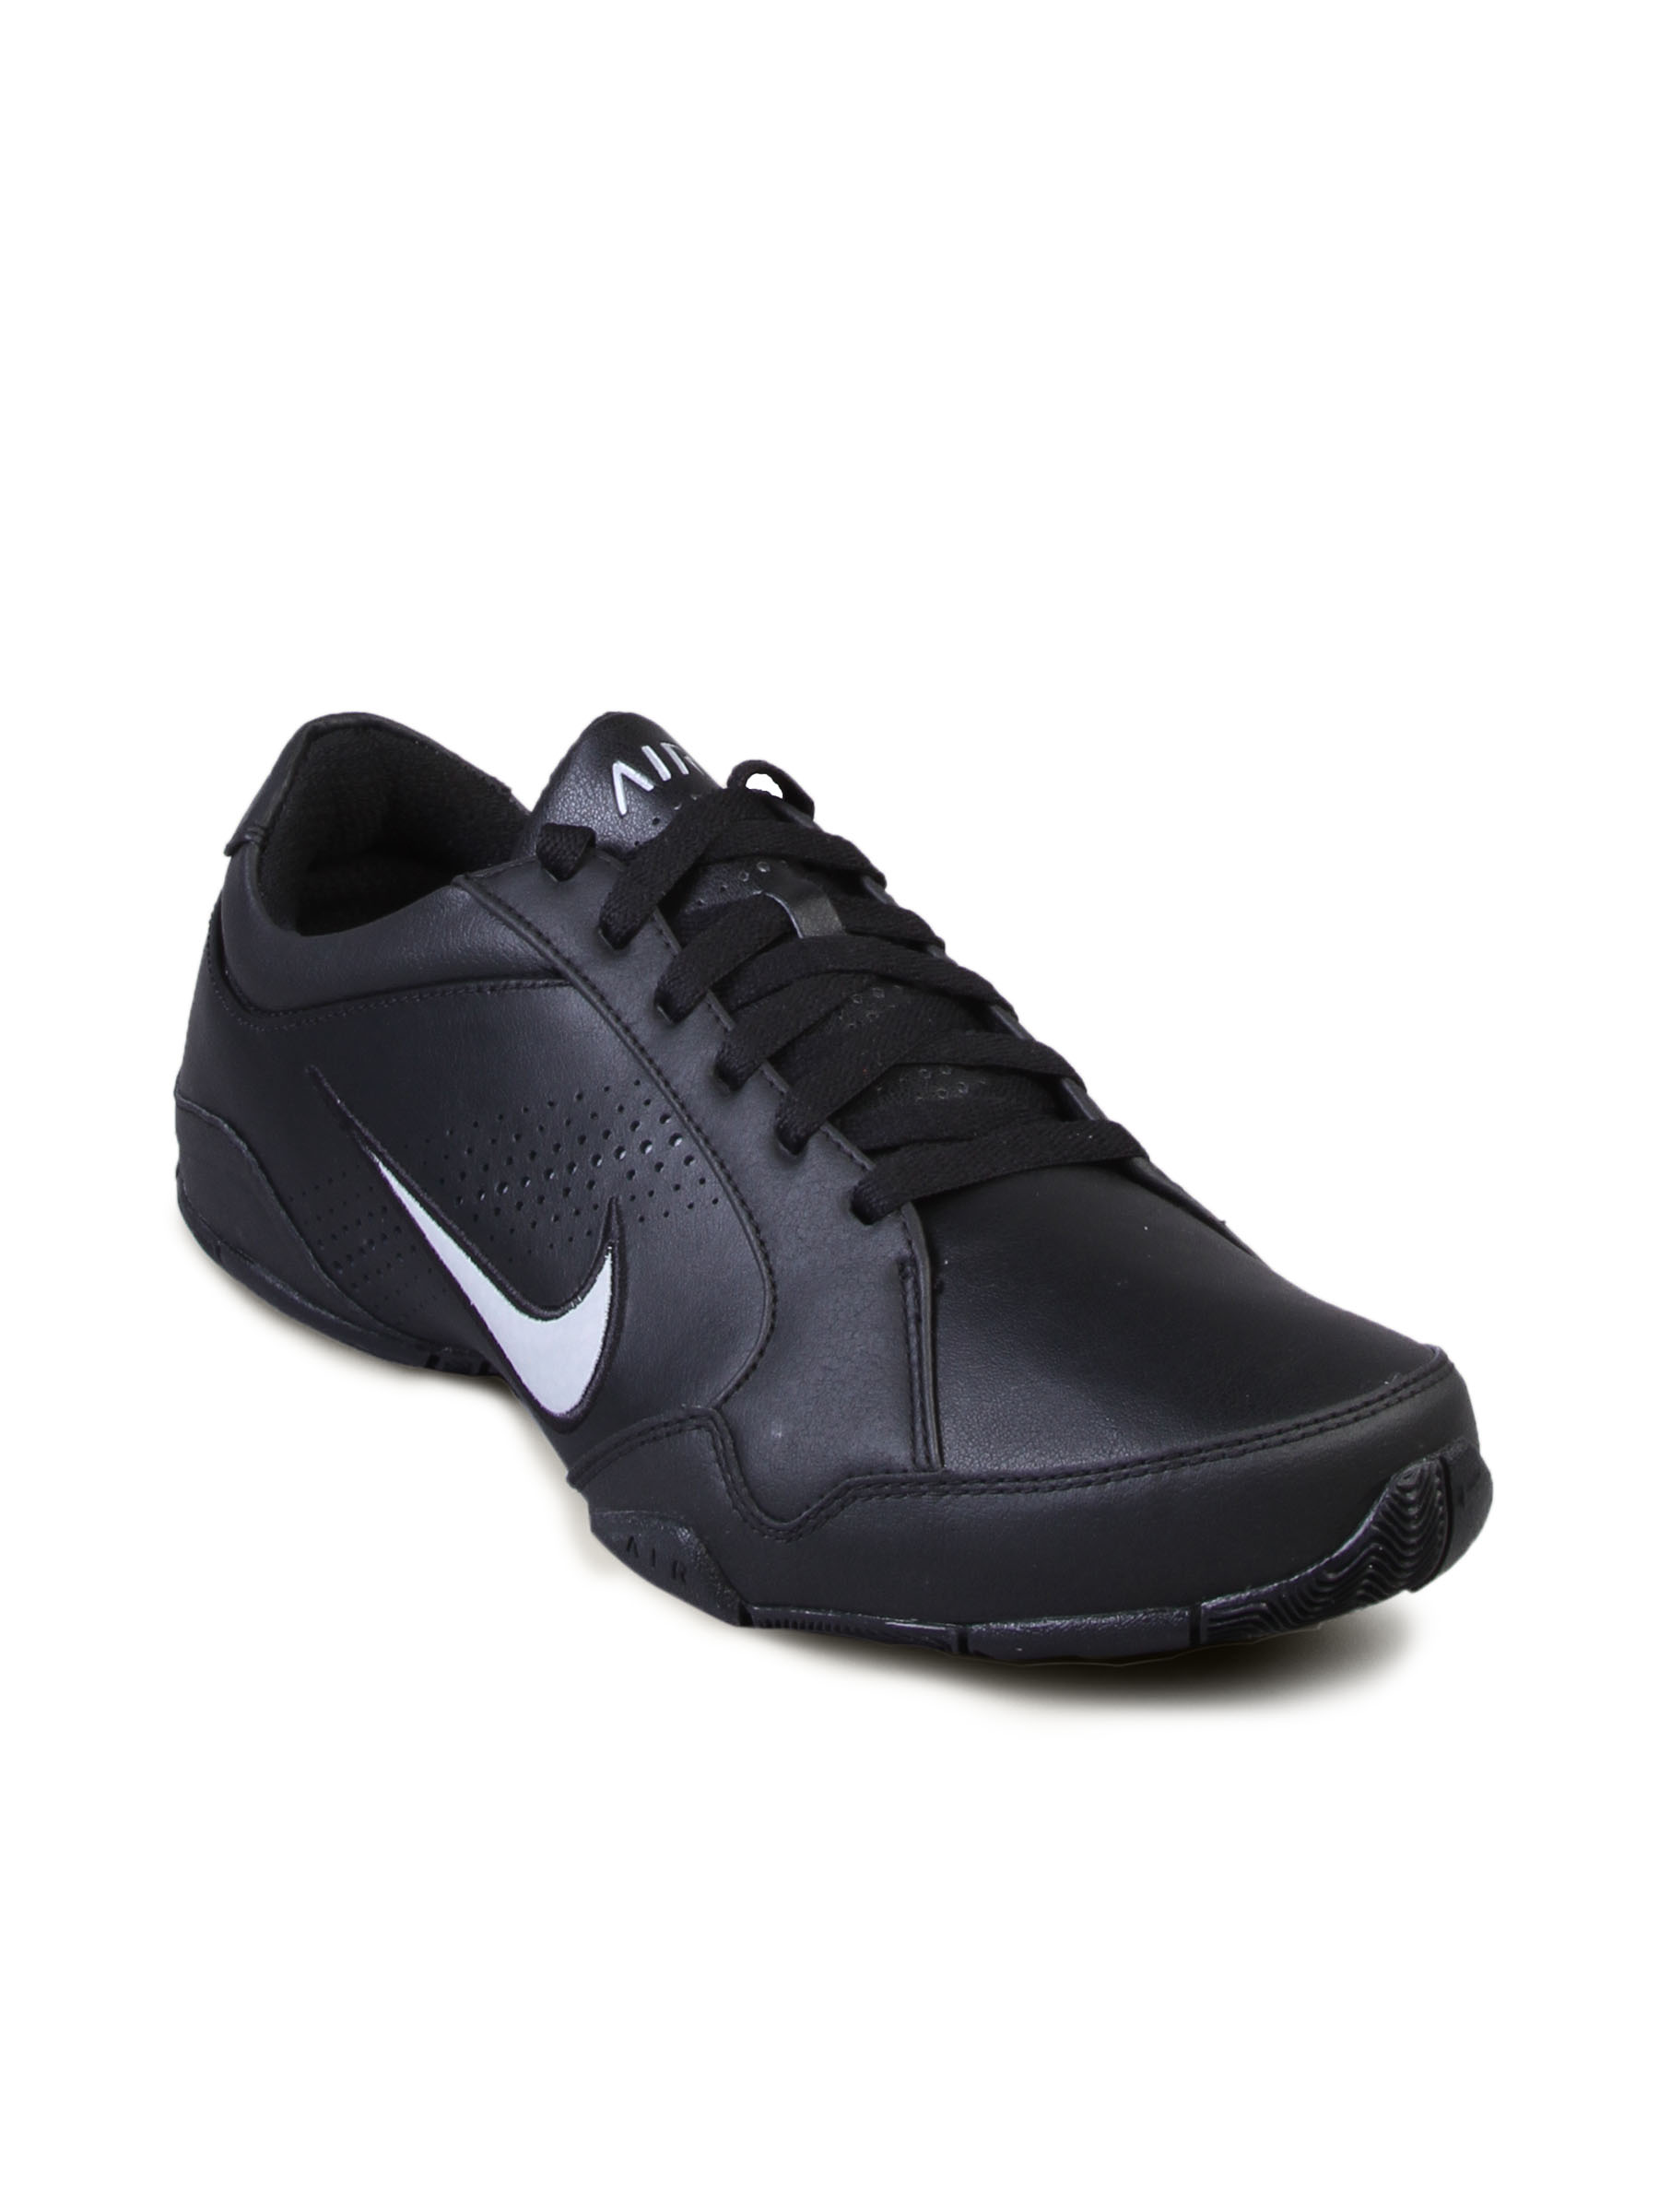

In [32]:
# Example text query
text_query = "black nike shoes"

# Get top recommendations using the pre-computed image features
top_recommendations = recommend(text_query, styles_df, image_features)

# Display top recommended images
from IPython.display import Image, display

for rec in top_recommendations:
    product_id, _ = rec
    # Ensure the path is correctly formed, considering the current directory or an absolute path
    image_path = styles_df.loc[styles_df['id'] == int(product_id), 'image_path'].values[0]
    display(Image(filename=image_path))
